# 📊 Bond Ladder Investment Calculator

## 🧠 What This Program Does

This tool helps you determine how much of your **existing capital** should be placed in **safe bond investments** to ensure you still have a specific amount — for example, **$5,000,000 by Dec 15, 2027**.

It breaks that goal into multiple **bond investments with staggered maturity dates** — forming a **bond ladder**.

Any remaining capital — not required to meet the future value target — can be used for **higher-reward growth investments**, such as **options trading, equities, or alternative assets**.

---

## 🎯 Objectives
- Generate a clear, human-readable **plan** showing:
  - Which bonds to invest in
  - How much to invest in each
  - When the investments mature
  - Amount remaining for **growth investments**
  
---

## 📌 How to Use
1. Input your target **future value** and **end date**.
2. The program selects available bonds that mature before the deadline.
3. It calculates how much to invest in each bond so the combined return meets your goal.
4. It prints a clean table and returns a detailed report as a DataFrame (Table).

---


In [15]:
from datetime import datetime, date
from collections import defaultdict
from dateutil.relativedelta import relativedelta
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import yfinance as yf

##### --- Global Configuration --- ####
FV_total = 5_000_000  # Future value target
date_end = datetime.strptime("12/15/2029", "%m/%d/%Y").date()
date_start = date.today()
##### ---------------------------- ####


def yearfrac(start_date: date, end_date: date) -> float:
    """Return the fraction of the year between two dates using actual/actual basis (365.25 days)."""
    delta_days = (end_date - start_date).days
    return delta_days / 365.25

# --- PV Calculation Function ---
def calculate_PV(ticker_price, FV, r_annual, start_date, end_date):
    months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
    r_monthly = r_annual / 12
    PV = FV / (1 + r_monthly) ** months
    amount = PV / ticker_price
    return PV, amount


## 🧾 Bond Ticker Class and Real-Time Data Import
This section defines a Ticker class to represent **bond ETFs**, including their price, interest rate, and maturity date. We then fetch live bond data using the **yfinance API**.

In [19]:
# --- Ticker Class ---
class Ticker:
    def __init__(self, ticker, price, rate, expiration_date, start_date=None):
        self.ticker = ticker
        self.price = price
        self.rate = rate
        self.expiration_date = datetime.strptime(expiration_date, "%m/%d/%Y").date()

    def __repr__(self):
        return (f"Ticker({self.ticker}, Price={self.price}, Rate={self.rate}, "
                f"Expires={self.expiration_date})")

# --- example Bond Data ---
# bonds = [
#     {"ticker": "BSCP", "price": 20.70, "rate": 0.04, "expiration_date": "12/15/2025"},
#     {"ticker": "BSCQ", "price": 19.51, "rate": 0.043, "expiration_date": "12/15/2026"},
#     {"ticker": "BSCR", "price": 19.60, "rate": 0.039, "expiration_date": "12/15/2027"},
#     {"ticker": "BSCS", "price": 20.38, "rate": 0.041, "expiration_date": "12/15/2028"},
#     {"ticker": "BSCT", "price": 18.57, "rate": 0.045, "expiration_date": "12/15/2029"}
# ]

# --- use API to fetch bonds 
def fetch_bond_data(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    info = ticker.info

    price = info.get("regularMarketPrice")
    yield_pct = info.get("yield")  # This is a trailing 12-month yield

    return {
        "ticker": ticker_symbol,
        "price": price,
        "rate": yield_pct if yield_pct is not None else 0.04,  # fallback
        "expiration_date": bond_expiration_map[ticker_symbol]
    }

# Map tickers to known maturity dates
bond_expiration_map = {
    "BSCP": "12/15/2025",
    "BSCQ": "12/15/2026",
    "BSCR": "12/15/2027",
    "BSCS": "12/15/2028",
    "BSCT": "12/15/2029"
}

# Fetch updated data for all
real_bond_data = [fetch_bond_data(ticker) for ticker in bond_expiration_map]

# Instantiate Ticker objects
tickers = [Ticker(**data) for data in real_bond_data]

print(f"{'Ticker':<6} | {'Price':<7} | {'Rate (%)':<9} | {'Expiration'}")
print("-" * 40)
for t in tickers:
    print(f"{t.ticker:<6} | ${t.price:<7.2f} | {t.rate*100:<9.2f} | {t.expiration_date}")



Ticker | Price   | Rate (%)  | Expiration
----------------------------------------
BSCP   | $20.67   | 4.09      | 2025-12-15
BSCQ   | $19.51   | 4.19      | 2026-12-15
BSCR   | $19.63   | 4.28      | 2027-12-15
BSCS   | $20.47   | 4.54      | 2028-12-15
BSCT   | $18.68   | 4.56      | 2029-12-15


## 🔁 `bond_ladder()` Function — Explained

The `bond_ladder()` function helps you build a **bond ladder strategy** by investing in a series of bonds that mature over time, instead of putting all your money into just one long-term bond.

---

### 🧠 What It Does

1. **Filters bonds** that expire within a target number of years (`years_to_target`).
2. **Sorts them** from latest to earliest expiration date.
3. **Allocates capital** starting from the latest bond:
   - Calculates the Present Value (PV) needed for your future goal.
4. **Allocate remaining** Invests the remaining capital across earlier-maturing bonds to provide a steady stream of returns over the target period.



📅 Start Date: 2025-06-27, End Date: 2029-12-15
📆 Total months between start and end date: 53
🗓️ Months remaining in 2025: 6
💸 Remaining future value to invest: $903,791.39
📈 Investment per month: $17,052.67

📊 Bond Ladder Plan:
Ticker     Maturity     Rate       PV Invested
BSCT       2029-12-15   4.56%    $4,096,208.61
BSCS       2028-12-15   4.54%    $  175,404.04
BSCR       2027-12-15   4.28%    $  184,520.46
BSCQ       2026-12-15   4.19%    $  192,662.07
BSCP       2025-12-15   4.09%    $  100,412.47

✅ Total Present Value Invested: $4,749,207.65
🚨 Funds Remaining: $250,792.35


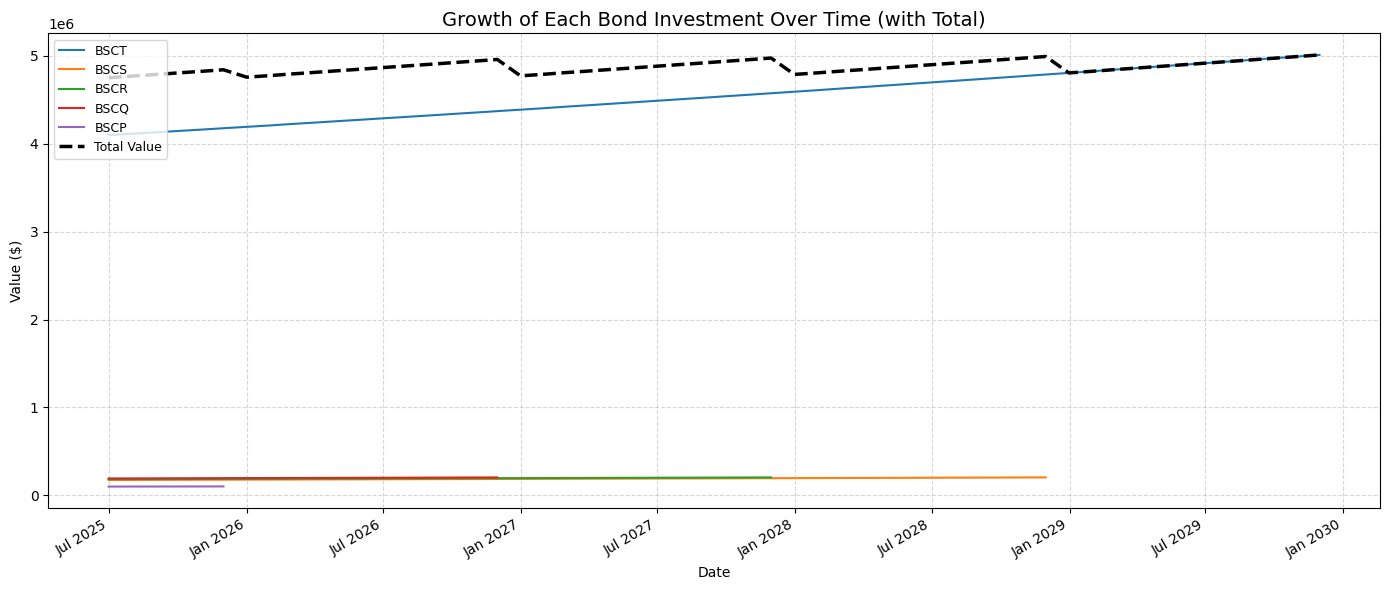

In [17]:
def yearfrac(start_date, end_date):
    """Calculate fractional year difference between two dates (Actual/365)."""
    return round((end_date - start_date).days / 365.0,5)

def bond_ladder(tickers, FV_total, start_date, end_date):
    """
    Calculate how much to invest in a ladder of safe, fixed-income instruments (bonds) 
    to ensure a known future value (FV_target), and determine how much capital remains 
    for other purposes (e.g., opchion investments).

    Parameters:
    -----------
    tickers : list
        A list of bond-like objects, each with:
            - ticker (str): bond identifier
            - price (float): price per unit
            - rate (float): annual interest rate (as a decimal, e.g., 0.05 for 5%)
            - expiration_date (date): the bond's maturity date

    FV_total : float
        The amount of money you have now — your total capital.

    start_date : date
        The date from which to start the ladder (usually today's date).

    end_date : date
        The latest maturity date you're targeting to reach your future value goal.
    """

    
    print(f"📅 Start Date: {start_date}, End Date: {end_date}")

    # Filter bonds that mature within range
    sorted_tickers = sorted(
        [t for t in tickers if start_date <= t.expiration_date <= end_date],
        key=lambda x: x.expiration_date,
        reverse=True
    )

    if not sorted_tickers:
        print("❌ No bonds available within the specified date range.")
        return

    ladder_plan = []

    # --- First investment ---
    first_ticker = sorted_tickers[0]
    nper = yearfrac(start_date, first_ticker.expiration_date)
    pv = npf.pv(rate=first_ticker.rate, nper=nper, pmt=0, fv=-FV_total)

    ladder_plan.append({
        "ticker": first_ticker.ticker,
        "price": first_ticker.price,
        "rate": first_ticker.rate,
        "expiration_date": first_ticker.expiration_date,
        "PV_invested": pv,
    })

    remaining_FV = FV_total - pv ## this is to calculate how much I can invest into other bonds 
    total_PV = pv

    # --- Time calculations ---
    delta = relativedelta(end_date, start_date)
    total_months = delta.years * 12 + delta.months
    months_left_this_year = 12 - start_date.month

    print(f"📆 Total months between start and end date: {total_months}")
    print(f"🗓️ Months remaining in {start_date.year}: {months_left_this_year}")
    print(f"💸 Remaining future value to invest: ${remaining_FV:,.2f}")

    # --- Monthly allocation ---
    invest_per_month = remaining_FV / total_months if total_months > 0 else 0
    print(f"📈 Investment per month: ${invest_per_month:,.2f}")

    # --- Middle investments ---
    for ticker in sorted_tickers[1:-1]:
        nper = yearfrac(start_date, ticker.expiration_date)
        fv_chunk = invest_per_month * 12
        pv = npf.pv(rate=ticker.rate, nper=nper, pmt=0, fv=-fv_chunk)

        ladder_plan.append({
            "ticker": ticker.ticker,
            "price": ticker.price,
            "rate": ticker.rate,
            "expiration_date": ticker.expiration_date,
            "PV_invested": pv,
        })

        total_PV += pv

    # --- Final investment ---
    last_ticker = sorted_tickers[-1]
    nper = yearfrac(start_date, last_ticker.expiration_date)
    
    fv_chunk = invest_per_month * months_left_this_year
    pv = npf.pv(rate=last_ticker.rate, nper=nper, pmt=0, fv=-fv_chunk)

    ladder_plan.append({
        "ticker": last_ticker.ticker,
        "price": last_ticker.price,
        "rate": last_ticker.rate,
        "expiration_date": last_ticker.expiration_date,
        "PV_invested": pv,
    })

    total_PV += pv
    

    # --- Summary ---
    print("\n📊 Bond Ladder Plan:")
    print(f"{'Ticker':<10} {'Maturity':<12} {'Rate':<6} {'PV Invested':>15}")
    for bond in ladder_plan:
        print(f"{bond['ticker']:<10} {bond['expiration_date']}   {bond['rate']:<6.2%}   ${bond['PV_invested']:>12,.2f}")


    print(f"\n✅ Total Present Value Invested: ${total_PV:,.2f}")
    print(
        f"🚨 Funds Remaining: ${FV_total - total_PV:,.2f}"
    )

    df = pd.DataFrame(ladder_plan)
    return df, total_PV

def plot_bond_growth(df, start_date):
    """
    Plot the growth of each bond's investment over time until its maturity,
    including a total combined value line.
    """

    # Convert date column if necessary
    if "expiration_date" in df.columns:
        df = df.rename(columns={"expiration_date": "Maturity"})
    elif "Maturity" not in df.columns:
        raise KeyError("Missing 'Maturity' or 'expiration_date' column in DataFrame.")

    # Prepare the figure
    fig, ax = plt.subplots(figsize=(14, 6))

    all_growth = pd.Series(dtype=float)

    for _, row in df.iterrows():
        maturity = pd.to_datetime(row["Maturity"])
        rate_annual = row["rate"]
        pv = row["PV_invested"]
        ticker = row["ticker"]

        growth_dates = pd.date_range(start_date, maturity, freq="ME")
        months = len(growth_dates)
        growth_values = [pv * (1 + rate_annual / 12) ** i for i in range(months)]
        growth_series = pd.Series(growth_values, index=growth_dates)

        all_growth = all_growth.add(growth_series, fill_value=0)
        ax.plot(growth_series.index, growth_series.values, label=ticker, linewidth=1.5)

    # Plot total value line
    ax.plot(all_growth.index, all_growth.values, label="Total Value", color='black', linewidth=2.5, linestyle='--')

    # Formatting
    ax.set_title("Growth of Each Bond Investment Over Time (with Total)", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value ($)")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(loc="upper left", fontsize=9)

    # Format x-axis for readability
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

    
df, total_pv = bond_ladder(tickers,FV_total,date_start,date_end)
plot_bond_growth(df, date_start)


## 💼 Options Bucket Allocation
This function allocates leftover funds (after building a bond ladder) into call options at time t = 0.

In [18]:
def allocate_options_bucket(remaining_funds, option_price_per_share=3.50, ticker="AAPL", expiration="01/17/2025", strike=150):
    """
    Allocate remaining funds into call options at t = 0.

    Parameters:
    -----------
    remaining_funds : float
        The cash available after the bond ladder is built.

    option_price_per_share : float
        Price of a single option (per share). Default is $3.50.

    Returns:
    --------
    dict containing:
        - number of contracts
        - total cost
        - remaining cash
    """
    contract_size = 100
    contract_cost = option_price_per_share * contract_size
    num_contracts = int(remaining_funds // contract_cost)
    total_cost = num_contracts * contract_cost
    leftover_cash = remaining_funds - total_cost

    print("\n📦 Options Bucket Allocation at t = 0")
    print(f"🎯 Underlying: {ticker} | Strike: ${strike} | Exp: {expiration}")
    print(f"🧾 Option Price: ${option_price_per_share:.2f} x 100 shares = ${contract_cost:.2f} per contract")
    print(f"📈 Contracts Purchased: {num_contracts}")
    print(f"💸 Total Cost: ${total_cost:,.2f}")
    print(f"💼 Remaining Cash: ${leftover_cash:,.2f}")

    return {
        "ticker": ticker,
        "strike": strike,
        "expiration": expiration,
        "option_price": option_price_per_share,
        "contracts_purchased": num_contracts,
        "total_cost": total_cost,
        "remaining_cash": leftover_cash
    }

remaining_funds = FV_total - total_pv
options_result = allocate_options_bucket(remaining_funds)


📦 Options Bucket Allocation at t = 0
🎯 Underlying: AAPL | Strike: $150 | Exp: 01/17/2025
🧾 Option Price: $3.50 x 100 shares = $350.00 per contract
📈 Contracts Purchased: 716
💸 Total Cost: $250,600.00
💼 Remaining Cash: $192.35
